# Online EdX experiment evaluation
A/B experiment was conducted on [CaltechDelftX: QuCryptox Quantum cryptography](https://courses.edx.org/courses/course-v1:CaltechDelftX+QuCryptox+3T2016) MOOC course offered by **Caltech University** and **TU Delft** at **EdX platform**. In this document, we are evaluating our proposed **question routing (recommendation of new questions) framework**. Users were split into three groups:

1. Question recommendation with educational-context group
2. Question recommendation without educational-context group
3. Control group without question recommendation


Course lasted 11 weeks from 3.10.2016 to 20.12.2016. Online experiment started 14.11.2016 (start of week \#6). Welcome category is not considered (category_id = 2).

In [71]:
# imports
import pandas as pd, numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import psycopg2 as pg
import pandas.io.sql as psql
import matplotlib
matplotlib.style.use('ggplot')
from IPython.display import display
import scipy.stats as stats

# graphics setup
%matplotlib inline
sns.set(color_codes=True)

# set up connection to the database
connection = pg.connect(database="askalot_edx_development", user="postgres", port=5432, 
                        host="localhost", password="")

## Users in recommendation groups are distributed evenly 

Users were sorted according to their answers count at the start of the online experiment. Subsequently, they were divided to groups by modulo operation of their order.

Pseudocode:
```
Sort users according to their answers count.
for i in lenght(sorted_users):
      ab_group[(i % 3) +1] <- sorted_users[i] 
```

In [72]:
ab_groups =  psql.read_sql("""SELECT id as ab_group_id, value as "Name" FROM ab_groups""", connection)
users = psql.read_sql("""SELECT g.id, g.value as "Name", COUNT(*) as "Count" FROM ab_groupings ab
                         JOIN ab_groups g ON g.id=ab.ab_group_id GROUP BY g.id ORDER BY g.id""", connection)
users

,id,Name,Count
0,1,Educational context,1304
1,2,Baseline,1305
2,3,Control,2073


Users who signed up for the course during online experiment did not get a recommendation, i.e they were assigned to the control group.

## Question routing recommended 118 questions during online experiment
Each question was recommended to both 10 most suitable users from educational-context group and to 10 most suitable users from group without educational context. 

In [73]:
answers_count = psql.read_sql("""
                                SELECT g.id, g.value, COUNT(DISTINCT(n.resource_id)) AS "Total number of recommended questions" 
                                FROM notifications as n 
                                JOIN ab_groupings ab ON ab.user_id = n.recipient_id 
                                JOIN ab_groups g ON g.id=ab.ab_group_id
                                WHERE n.action = 'recommendation' AND n.created_at < '2016-12-20'
                                GROUP BY g.id
                              """, connection)
rec_count = psql.read_sql("""
                                SELECT g.id, COUNT(DISTINCT(n.id)) AS "Total number of generated recommendations" 
                                FROM notifications as n 
                                JOIN ab_groupings ab ON ab.user_id = n.recipient_id 
                                JOIN ab_groups g ON g.id=ab.ab_group_id
                                WHERE n.action = 'recommendation' AND n.created_at < '2016-12-20'
                                GROUP BY g.id
                              """, connection)
rec_count = pd.merge(answers_count, rec_count, on="id", how='inner')
rec_count[['value', 'Total number of recommended questions', 'Total number of generated recommendations']]

,value,Total number of recommended questions,Total number of generated recommendations
0,Educational context,118,1163
1,Baseline,118,1173


## Recommendation click-through rate was more than 20%
Recommendation was sent to users by two channels:

1. as a notification in Askalot CQA system
2. personlized recommended list of questions is shown on user dashboard 

Click-through rate is computed as portion of read recommendations to total number of recommendations.

,Absolute count,Unique users,Total CTR
0,491,73,0.208051


,value,Unique users,CTR
0,Educational context,37,0.111441
1,Baseline,33,0.088983


,From dashboard,Absolute count,Unique users,Portion of CTR
0,False,433,61,0.881874
1,True,58,23,0.118126


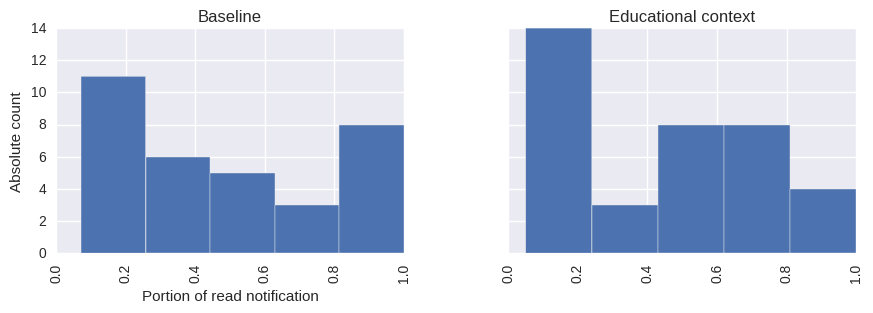

In [74]:
ctr = psql.read_sql("""   
    SELECT COUNT(n.recipient_id) as "Absolute count", COUNT(DISTINCT(n.recipient_id)) AS "Unique users", CAST(COUNT(n.id) AS FLOAT) / (SELECT COUNT(*) FROM notifications WHERE action= 'recommendation' AND created_at < '2016-12-20') as "Total CTR"
    FROM notifications as n WHERE n.action= 'recommendation' AND n.unread = FALSE AND n.created_at < '2016-12-20'
    """,connection)
display(ctr)

ctr_by_groups = psql.read_sql("""
    SELECT g.value, COUNT(DISTINCT(n.recipient_id)) AS "Unique users", CAST(COUNT(n.recipient_id) AS FLOAT) / (SELECT COUNT(*) FROM notifications WHERE action= 'recommendation' AND created_at < '2016-12-20') as "CTR"
    FROM notifications as n 
    JOIN ab_groupings ab ON ab.user_id = n.recipient_id
    JOIN ab_groups g ON g.id=ab.ab_group_id
    WHERE n.action= 'recommendation' AND n.unread = FALSE AND n.created_at < '2016-12-20'
    GROUP BY g.id ORDER BY g.id
    """, connection)
display(ctr_by_groups)

ctr_from_dashboard = psql.read_sql("""   
    SELECT n.from_dashboard AS "From dashboard", COUNT(n.recipient_id) as "Absolute count", COUNT(DISTINCT(n.recipient_id)) AS "Unique users", CAST(COUNT(n.recipient_id) AS FLOAT) / (SELECT COUNT(*) FROM notifications WHERE action= 'recommendation' AND unread=FALSE AND created_at < '2016-12-20') as "Portion of CTR" 
    FROM notifications as n WHERE n.action= 'recommendation' AND n.unread = FALSE  AND n.created_at < '2016-12-20' GROUP BY n.from_dashboard """,connection)
display(ctr_from_dashboard)

ctr_by_users = psql.read_sql("""
    SELECT g.value, n.recipient_id, COUNT(n.id)::float / (SELECT COUNT(*) FROM notifications x WHERE x.action= 'recommendation' AND n.recipient_id=x.recipient_id) AS "portion"
    FROM notifications as n 
    JOIN ab_groupings ab ON ab.user_id = n.recipient_id
    JOIN ab_groups g ON g.id=ab.ab_group_id
    WHERE n.action= 'recommendation' AND n.unread = FALSE AND n.created_at < '2016-12-20'
    GROUP BY g.id, n.recipient_id ORDER BY g.id, COUNT(n.id) DESC
    """, connection)

ax = ctr_by_users.hist(by='value',column = 'portion', bins=5, layout=(1,2), sharey=True, figsize=(10, 3))
ax[0].set(xlabel='Portion of read notification', ylabel="Absolute count")

Group with educational context has better CTR by 2.2% and it has 3 more unique users who read any recommendation. 

From the histogram above, it is possible to see that baseline group has more users who read all of the recommendations.

Notifications were 8 times more efficient for sending a recommendation than list of questions at the dasboard.

### Question routing with educational-context has better recommendation success rate
Recommendation success rate is portion of recommendations which were answered or commented by the recipient of the recommendation to total number of recommendated questions.

In [75]:
answers_success_rec = psql.read_sql("""
    SELECT ab.ab_group_id, n.id as n_id, n.created_at, n.unread, n.read_at, n.from_dashboard, q.title, q.author_id, q.text, q.created_at, a.id, a.author_id, a.text, a.created_at, a.votes_difference
    FROM notifications as n INNER JOIN questions q ON q.id = n.resource_id INNER JOIN answers a ON n.recipient_id = a.author_id AND q.id=a.question_id 
    INNER JOIN ab_groupings ab ON ab.user_id = n.recipient_id WHERE n.action= 'recommendation'
    """,connection)

comments_success_rec = psql.read_sql("""
    SELECT ab.ab_group_id, n.id as n_id, n.created_at, n.unread, n.read_at, n.from_dashboard, q.title, q.author_id, q.text, q.created_at, c.id, c.author_id, c.text, c.created_at, 0 as votes_difference
    FROM notifications as n INNER JOIN questions q ON q.id = n.resource_id INNER JOIN comments c ON (n.recipient_id = c.author_id AND q.id=c.commentable_id AND c.commentable_type = 'Shared::Question') 
    INNER JOIN ab_groupings ab ON ab.user_id = n.recipient_id WHERE n.action= 'recommendation'
    """,connection)

success_rec = pd.concat([answers_success_rec, comments_success_rec])

success_rec = success_rec.groupby('ab_group_id')['n_id'].count().to_frame(name = 'success_count').reset_index()
success_rec = pd.merge(success_rec, rec_count, left_on='ab_group_id', right_on="id", how='inner')
success_rec['success_portion'] = success_rec['success_count'] / success_rec['Total number of recommended questions']
success_rec.rename(columns={'success_portion': 'Recommendation success rate'}, inplace=True)
display(success_rec[['value', 'success_count', 'Total number of generated recommendations', 'Total number of recommended questions', 'Recommendation success rate']])
print("Effect size %.2f%%" % ((success_rec.ix[0]['Recommendation success rate'] - success_rec.ix[1]['Recommendation success rate'])*100))

,value,success_count,Total number of generated recommendations,Total number of recommended questions,Recommendation success rate
0,Educational context,22,1163,118,0.186441
1,Baseline,5,1173,118,0.042373


Effect size 14.41%


Educational context is better by 14.41% in recommendation success rate in comparison with baseline approach. It can be explained by:

- more accurate recommendation
- large part of users in baseline group dropped out from the course

## Counts before and during online experiment
It is important to mention that online experiment was conducted from week \#6 to the end of the course (week \#10), i.e. for the period of 5 weeks during the course. In comparison, the period before the online experiment lasted from week \#0 to week \#5 inclusive, i.e. for the period of 6 weeks. Absolute counts are nearly doubled in most of the measured metrics which is caused by:
- not equal periods
- the course was getting harder each week and less users stayed active which is natural phenomenon of the MOOC course

### Question counts before and during online experiment

In [76]:
questions_end = psql.read_sql("SELECT q.author_id, ab.ab_group_id FROM questions q JOIN ab_groupings ab ON q.author_id = ab.user_id "+
                          "WHERE q.created_at >= '2016-11-14' AND q.created_at < '2016-12-20'", connection)
questions_start = psql.read_sql("SELECT q.author_id, ab.ab_group_id FROM questions q JOIN ab_groupings ab ON q.author_id = ab.user_id "+
                          "WHERE q.created_at < '2016-11-14'", connection)

print("Questions absolute counts:")
print("\tbefore online experiment: \t%d" % questions_start.shape[0])
print("\tduring online experiment: \t%d" % questions_end.shape[0])

Questions absolute counts:
	before online experiment: 	241
	during online experiment: 	118


Note: Deletion of some questions by users cause the difference between recommended questions and total number of questions during online experiment.  

### Answers count before and during online experiment

In [77]:
answers_end = psql.read_sql("SELECT a.author_id, ab.ab_group_id FROM answers a JOIN ab_groupings ab ON a.author_id = ab.user_id "+
                          "JOIN questions q ON q.id=a.question_id WHERE a.created_at >= '2016-11-14' AND a.created_at < '2016-12-20'", connection)
answers_start = psql.read_sql("SELECT a.author_id, ab.ab_group_id FROM answers a JOIN ab_groupings ab ON a.author_id = ab.user_id "+
                          "JOIN questions q ON q.id=a.question_id WHERE a.created_at < '2016-11-14'", connection)

print("Answers absolute counts:")
print("\tbefore online experiment: \t%d" % answers_start.shape[0])
print("\tduring online experiment: \t%d" % answers_end.shape[0])

Answers absolute counts:
	before online experiment: 	250
	during online experiment: 	135


### Comments count before and during online experiment

In [78]:
comments_end = psql.read_sql("SELECT c.author_id, ab.ab_group_id FROM comments c JOIN ab_groupings ab ON c.author_id = ab.user_id "+
                          "WHERE c.created_at >= '2016-11-14' AND c.created_at < '2016-12-20'", connection)
comments_start = psql.read_sql("SELECT c.author_id, ab.ab_group_id FROM comments c JOIN ab_groupings ab ON c.author_id = ab.user_id "+
                          "WHERE c.created_at < '2016-11-14'", connection)

print("Coments absolute counts:")
print("\tbefore online experiment: \t%d" % comments_start.shape[0])
print("\tduring online experiment: \t%d" % comments_end.shape[0])

Coments absolute counts:
	before online experiment: 	383
	during online experiment: 	167


### Course interaction before and during online experiment

In [79]:
interaction_end = psql.read_sql("SELECT l.lister_id, ab.ab_group_id FROM lists l JOIN ab_groupings ab ON l.lister_id = ab.user_id "+
                          "WHERE l.created_at >= '2016-11-14' AND l.created_at < '2016-12-20'", connection)
interaction_start = psql.read_sql("SELECT l.lister_id, ab.ab_group_id FROM lists l JOIN ab_groupings ab ON l.lister_id = ab.user_id "+
                          "WHERE l.created_at < '2016-11-14'", connection)

print("Course interactions:")
print("\tbefore online experiment: \t%d" % interaction_start.shape[0])
print("\tduring online experiment: \t%d" % interaction_end.shape[0])

print("Unique users interacting in the course:")
print("\tbefore online experiment: \t%d" % interaction_start['lister_id'].nunique())
print("\tduring online experiment: \t%d" % interaction_end['lister_id'].nunique())

Course interactions:
	before online experiment: 	55540
	during online experiment: 	61036
Unique users interacting in the course:
	before online experiment: 	2436
	during online experiment: 	1398


Unique users during online course decreased by factor of 3. Surprisingly, even with the decrease in active users the number of interactions during experiment with the course or CQA system stayed similar.

## Groups with question recommendation have more question views than control group 

Question views:
	before online experiment: 	10995
	during online experiment: 	 7238


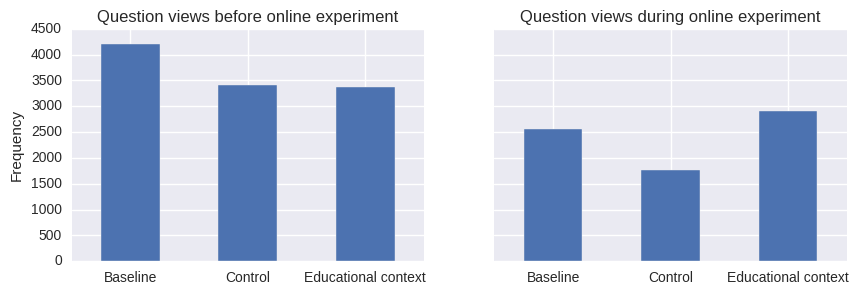

In [80]:
# read questions and filter columns
views_end = psql.read_sql("SELECT v.viewer_id, ab.ab_group_id, g.value AS ab_group FROM views v JOIN ab_groupings ab ON v.viewer_id = ab.user_id "+
                          "JOIN ab_groups g ON g.id=ab.ab_group_id "+
                          "WHERE v.created_at >= '2016-11-14' AND v.created_at < '2016-12-20'", connection)
views_start = psql.read_sql("SELECT v.viewer_id, ab.ab_group_id, g.value AS ab_group FROM views v JOIN ab_groupings ab ON v.viewer_id = ab.user_id "+
                            "JOIN ab_groups g ON g.id=ab.ab_group_id "+
                            "WHERE v.created_at < '2016-11-14'", connection)
print("Question views:")
print("\tbefore online experiment: \t%5.d" % views_start.shape[0])
print("\tduring online experiment: \t%5.d" % views_end.shape[0])


# Histogram views before
views_by_groups = views_start.groupby('ab_group')["viewer_id"].count()

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,3))
views_by_groups.plot(kind="bar", title="Question views before online experiment", ax = ax1, rot=0)
ax1.set(xlabel='', ylabel='Frequency')

# Histogram views during
views_by_groups = views_end.groupby('ab_group')["viewer_id"].count()

views_by_groups.plot(kind="bar", title="Question views during online experiment", ax=ax2, rot=0)
ax2.set(xlabel='', ylabel='Frequency')

### Only 17% of baseline group contributors remained contributing during online experiment
Comparing contributing users (answering, commenting) before the online experiment and during the online experiment.

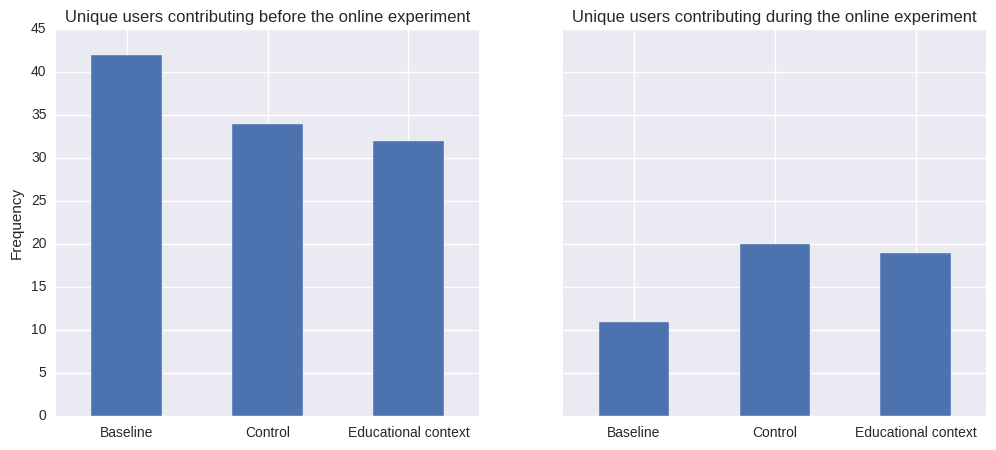

In [81]:
users_start = psql.read_sql("""
    SELECT DISTINCT(a.author_id), a.ab_group_id, g.value AS ab_group FROM
    ((SELECT a.author_id, ab.ab_group_id FROM answers a JOIN ab_groupings ab ON a.author_id = ab.user_id
    JOIN questions q ON q.id=a.question_id JOIN ab_groups g ON g.id=ab.ab_group_id
    WHERE a.created_at < '2016-11-14')
    UNION ALL
    (SELECT c.author_id, ab.ab_group_id FROM comments c JOIN ab_groupings ab ON c.author_id = ab.user_id
    WHERE c.created_at < '2016-11-14')
    ) as a
    JOIN ab_groups g ON g.id=a.ab_group_id
    """, connection)

users_during = psql.read_sql("""
    SELECT DISTINCT(a.author_id), a.ab_group_id, g.value AS ab_group FROM
    ((SELECT a.author_id, ab.ab_group_id FROM answers a JOIN ab_groupings ab ON a.author_id = ab.user_id
    JOIN questions q ON q.id=a.question_id
    WHERE a.created_at >= '2016-11-14' AND a.created_at < '2016-12-20')
    UNION ALL
    (SELECT c.author_id, ab.ab_group_id FROM comments c JOIN ab_groupings ab ON c.author_id = ab.user_id
    WHERE c.created_at >= '2016-11-14' AND c.created_at < '2016-12-20')
    ) as a
    JOIN ab_groups g ON g.id=a.ab_group_id
    """, connection)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,5))
users_start.groupby('ab_group')["author_id"].count().plot(kind="bar", ax=ax1, title="Unique users contributing before the online experiment", rot=0)
ax1.set(xlabel='', ylabel='Frequency')
users_during.groupby('ab_group')["author_id"].count().plot(kind="bar", ax=ax2, title="Unique users contributing during the online experiment", rot=0)
ax2.set(xlabel='', ylabel='Frequency')

In [82]:
edu_remained_u = users_during[users_during['ab_group_id'] == 1]['author_id'].isin(users_start[users_start['ab_group_id'] == 1]['author_id'])
baseline_remained_u = users_during[users_during['ab_group_id'] == 2]['author_id'].isin(users_start[users_start['ab_group_id'] == 2]['author_id'])
control_remained_u = users_during[users_during['ab_group_id'] == 3]['author_id'].isin(users_start[users_start['ab_group_id'] == 3]['author_id'])


print("From users contributed before online, how many continues contributing during online experiment:")
print("\t Recommendation with educational context: \t%2.d from %d \t= %.2f%%" % (len(users_during[users_during['ab_group_id'] == 1][edu_remained_u]), len(users_start[users_start['ab_group_id'] == 1]), len(users_during[users_during['ab_group_id'] == 1][edu_remained_u]) / float(len(users_start[users_start['ab_group_id'] == 1]))))
print("\t Baseline recommendation: \t\t\t%2.d from %d \t= %.2f%%" % (len(users_during[users_during['ab_group_id'] == 2][baseline_remained_u]), len(users_start[users_start['ab_group_id'] == 2]), len(users_during[users_during['ab_group_id'] == 2][baseline_remained_u])/ float(len(users_start[users_start['ab_group_id'] == 2]))))
print("\t Control group: \t\t\t\t%2.d from %d \t= %.2f%%" % (len(users_during[users_during['ab_group_id'] == 3][control_remained_u]), len(users_start[users_start['ab_group_id'] == 3]), len(users_during[users_during['ab_group_id'] == 3][control_remained_u]) / float(len(users_start[users_start['ab_group_id'] == 3]))))

print("New contributors compared to all contributors during online experiment:")
edu_new_u = users_during[users_during['ab_group_id'] == 1][~edu_remained_u]
print("\t Recommendation with educational context: \t%2.d from %d \t= %.3f%%" % ( len(edu_new_u), len(users_during[users_during['ab_group_id'] == 1]), len(edu_new_u) / float(len(users_during[users_during['ab_group_id'] == 1]))))
baseline_new_u = users_during[users_during['ab_group_id'] == 2][~baseline_remained_u]
print("\t Baseline recommendation: \t\t\t%2.d from %d \t= %.3f%%" % (len(baseline_new_u), len(users_during[users_during['ab_group_id'] == 2]), len(baseline_new_u) / float(len(users_during[users_during['ab_group_id'] == 2]))))
control_new_u = users_during[users_during['ab_group_id'] == 3][~control_remained_u]
print("\t Control group: \t\t\t\t%2.d from %d \t= %.3f%%" % (len(control_new_u), len(users_during[users_during['ab_group_id'] == 3]), len(control_new_u) / float(len(users_during[users_during['ab_group_id'] == 3]))))

From users contributed before online, how many continues contributing during online experiment:
	 Recommendation with educational context: 	11 from 32 	= 0.34%
	 Baseline recommendation: 			 7 from 42 	= 0.17%
	 Control group: 				 9 from 34 	= 0.26%
New contributors compared to all contributors during online experiment:
	 Recommendation with educational context: 	 8 from 19 	= 0.421%
	 Baseline recommendation: 			 4 from 11 	= 0.364%
	 Control group: 				11 from 20 	= 0.550%


Users interacting with the course decreased during the online course. The course got harder and it is typical pattern present in the MOOC courses. However, in the baseline group the effect is very big.

**Control group has highest percentage of new contributors who did not contribute before online experiment, which is not according to our hypothesis.** It might be related with a higher number of users in control group than in the other two groups as newly registered users during online experiment were assigned to control group.

In [83]:
# Create before and during dataframe with answer, question and comments counts

# Before
# questions
question_by_groups = questions_start.groupby('ab_group_id')["author_id"].count()
start_df = question_by_groups.to_frame(name = 'questions_count').reset_index()
# answers
answers_by_groups = answers_start.groupby('ab_group_id')["author_id"].count()
temp = answers_by_groups.to_frame(name = 'answers_count').reset_index()
start_df = pd.merge(start_df, temp, on='ab_group_id', how='inner')
# comments
comments_by_groups = comments_start.groupby('ab_group_id')["author_id"].count()
temp = comments_by_groups.to_frame(name = 'comments_count').reset_index()
start_df = pd.merge(start_df, temp, on='ab_group_id', how='inner')
# Interactions
interactions_by_groups = interaction_start.groupby('ab_group_id')["lister_id"].count()
temp = interactions_by_groups.to_frame(name = 'interactions_count').reset_index()
start_df = pd.merge(start_df, temp, on='ab_group_id', how='inner')
# Unique users interacting
interactions_by_groups = interaction_start.groupby('ab_group_id')["lister_id"].nunique()
temp = interactions_by_groups.to_frame(name = 'unique_users_interacting').reset_index()
start_df = pd.merge(start_df, temp, on='ab_group_id', how='inner')
# Unique users contributing
contributing_users_by_groups = users_start.groupby(['ab_group_id', 'ab_group'])["author_id"].nunique()
temp = contributing_users_by_groups.to_frame(name = 'unique_users_contributing').reset_index()
start_df = pd.merge(start_df, temp, on='ab_group_id', how='inner')


print("Statistics for groups before online experiment")
display(start_df[['ab_group', 'questions_count', 'answers_count', 'comments_count', 'interactions_count', 'unique_users_interacting', 'unique_users_contributing']])

# During
# questions
question_by_groups = questions_end.groupby('ab_group_id')["author_id"].count()
end_df = question_by_groups.to_frame(name = 'questions_count').reset_index()
# answers
answers_by_groups = answers_end.groupby('ab_group_id')["author_id"].count()
temp = answers_by_groups.to_frame(name = 'answers_count').reset_index()
end_df = pd.merge(end_df, temp, on='ab_group_id', how='inner')
# comments
comments_by_groups = comments_end.groupby('ab_group_id')["author_id"].count()
temp = comments_by_groups.to_frame(name = 'comments_count').reset_index()
end_df = pd.merge(end_df, temp, on='ab_group_id', how='inner')
# interactions
interactions_by_groups = interaction_end.groupby('ab_group_id')["lister_id"].count()
temp = interactions_by_groups.to_frame(name = 'interactions_count').reset_index()
end_df = pd.merge(end_df, temp, on='ab_group_id', how='inner')
# Unique users interacting
interactions_by_groups = interaction_end.groupby('ab_group_id')["lister_id"].nunique()
temp = interactions_by_groups.to_frame(name = 'unique_users_interacting').reset_index()
end_df = pd.merge(end_df, temp, on='ab_group_id', how='inner')
# Unique users contributing
interactions_by_groups = users_during.groupby(['ab_group_id', 'ab_group'])["author_id"].nunique()
temp = interactions_by_groups.to_frame(name = 'unique_users_contributing').reset_index()
end_df = pd.merge(end_df, temp, on='ab_group_id', how='inner')

print("Statistics for groups during online experiment")
display(end_df[['ab_group', 'questions_count', 'answers_count', 'comments_count', 'interactions_count', 'unique_users_interacting', 'unique_users_contributing']])

Statistics for groups before online experiment


,ab_group,questions_count,answers_count,comments_count,interactions_count,unique_users_interacting,unique_users_contributing
0,Educational context,88,97,131,19178,814,32
1,Baseline,84,75,125,18752,811,42
2,Control,69,78,127,17610,811,34


Statistics for groups during online experiment


,ab_group,questions_count,answers_count,comments_count,interactions_count,unique_users_interacting,unique_users_contributing
0,Educational context,45,79,94,29909,282,19
1,Baseline,47,6,45,11311,267,11
2,Control,26,50,28,19816,849,20


Absolute numbers are shown in the tables above. They are visualized below.

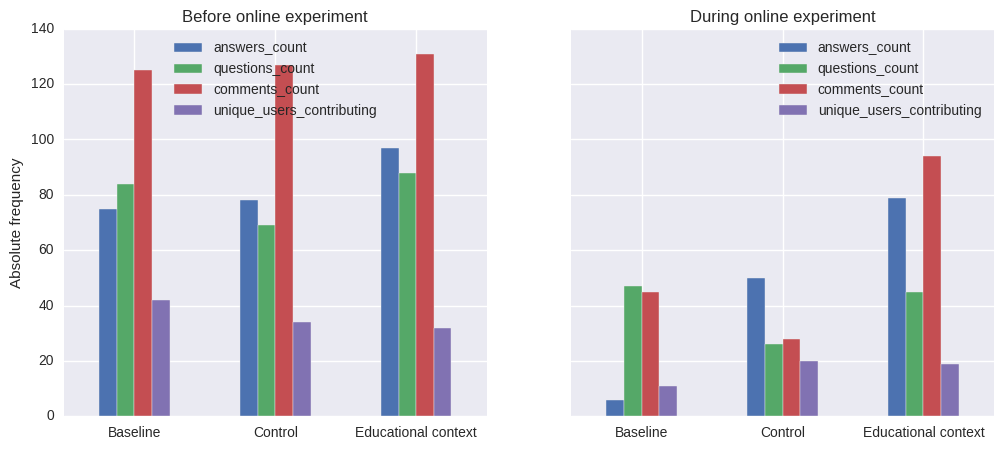

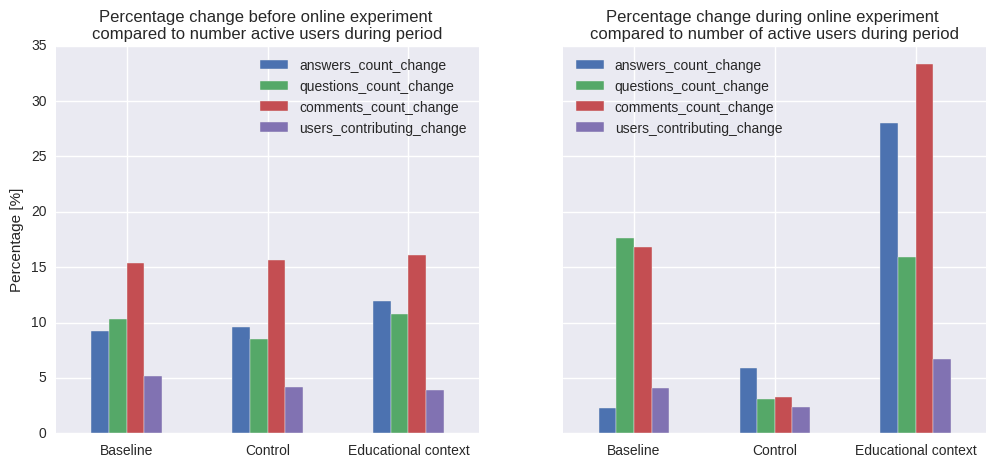

In [84]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,5))
start_df.groupby('ab_group')["answers_count", "questions_count", "comments_count", "unique_users_contributing"].sum().plot(ax=ax1, kind="bar", title="Before online experiment", rot=0)
ax1.set(xlabel='', ylabel='Absolute frequency')

end_df.groupby('ab_group')["answers_count", "questions_count", "comments_count", "unique_users_contributing"].sum().plot(ax=ax2, kind="bar", title="During online experiment", rot=0)
ax2.set(xlabel='', ylabel='Absolute frequency')

# Normalization by number of active users
start_df['questions_count_change']= start_df['questions_count']*100 / start_df['unique_users_interacting']
start_df['answers_count_change']= start_df['answers_count']*100 / start_df['unique_users_interacting']
start_df['comments_count_change']= start_df['comments_count']*100 / start_df['unique_users_interacting']
start_df['users_contributing_change']= start_df['unique_users_contributing']*100 / start_df['unique_users_interacting']
end_df['questions_count_change']= end_df['questions_count']*100 / end_df['unique_users_interacting']
end_df['answers_count_change']= end_df['answers_count']*100 / end_df['unique_users_interacting']
end_df['comments_count_change']= end_df['comments_count']*100 / end_df['unique_users_interacting']
end_df['users_contributing_change']= end_df['unique_users_contributing']*100 / end_df['unique_users_interacting']

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,5))
start_df.groupby('ab_group')["answers_count_change", "questions_count_change", "comments_count_change", "users_contributing_change"].sum()\
    .plot(kind="bar", title="Percentage change before online experiment \ncompared to number active users during period", ax=ax1, rot=0)
ax1.set(xlabel='', ylabel='Percentage [%]')

end_df.groupby('ab_group')["answers_count_change", "questions_count_change", "comments_count_change", "users_contributing_change"].sum()\
    .plot(kind="bar", title="Percentage change during online experiment \ncompared to number of active users during period", ax=ax2, rot=0)
ax2.set(xlabel='', ylabel='Percentage [%]')

**Question recommendation with educational context clearly outperformed baseline approach in contributions.** From percentage of change during online experiment compared to number of active users during period it is possible to see that question recommendation with educational context clearly outperformed other groups in number of answers and number of comments. 

**Question recommendation involved more users into question answering.** By considering number of contributing users one can see that question recommendation with educational context and baseline approach involved more unique users into contributing compared to the control group. 

Baseline question recommendation has highest number of asked questions.

**Question recommendation has more contibutions in comparison to control group without recommendation.** We consider contribution to question answering by either answering or commenting a question. When we sum number of answers and comments, question recommendation clearly outperformed control group without a recommendation.  

### Question recommendation lowered instructors load by 4%

In [85]:
prof_answers_before = psql.read_sql("SELECT COUNT(a.author_id) FROM answers a JOIN ab_groupings ab ON a.author_id = ab.user_id "
                    "JOIN questions q ON q.id=a.question_id WHERE a.created_at < '2016-11-14' AND a.author_id = 4", connection)
print("Professor answers before online experiment: %d" % prof_answers_before['count'])

TAs = psql.read_sql("""SELECT DISTINCT(user_id) FROM assignments""",connection)

contributions = psql.read_sql("""
    SELECT a.author_id, ab.ab_group_id, a.created_at FROM answers a JOIN ab_groupings ab ON a.author_id = ab.user_id
    JOIN questions q ON q.id=a.question_id
    UNION ALL
    SELECT c.author_id, ab.ab_group_id, c.created_at FROM comments c JOIN ab_groupings ab ON c.author_id = ab.user_id
    """, connection)

total_end_contributions = answers_end.shape[0] + comments_end.shape[0]
total_before_contributions = answers_start.shape[0] + comments_start.shape[0]

print("Teaching assistants contributions compared to all contributions:")
contributions_before = contributions[(contributions['created_at'] < '2016-11-14')]
print("\tbefore online experiment: %.2f%%." % (contributions_before['author_id'].isin(TAs['user_id']).sum()*100 / float(total_before_contributions)))

contributions_end = contributions[(contributions['created_at'] >= '2016-11-14') & (contributions['created_at'] < '2016-12-20')]
print("\tduring online experiment: %.2f%%" % (contributions_end['author_id'].isin(TAs['user_id']).sum()*100 / float(total_end_contributions)))
#contributions_end[~contributions_end['author_id'].isin(TAs['user_id'])]['author_id'].count()

Professor answers before online experiment: 45
Teaching assistants contributions compared to all contributions:
	before online experiment: 34.60%.
	during online experiment: 30.79%


Note: Professor is part of group 1 and he had 45 answers before online experiment (nearly half of answers for group 1), which caused not equal distribution of answers count when splitting users to the groups.  

## Proposed question routing framework has covered 48% of active CQA users. 
Recommendation coverage - how many unique users did get the recommendation? 

Active users are users who have seen at least one question in CQA system.

In [86]:
users_coverage = psql.read_sql("""
    WITH active_users AS (
      SELECT COUNT(*) from users u JOIN ab_groupings ab ON u.id = ab.user_id 
      WHERE u.views_count > 0 AND ab.ab_group_id != 3
    )
    SELECT g.value AS ab_group, COUNT(DISTINCT(ab.user_id)) AS total_recommended_to_users, (SELECT * FROM active_users) AS total_active_users, 
    COUNT(DISTINCT(ab.user_id)) / (SELECT * FROM active_users)::float AS user_coverage FROM notifications as n 
    JOIN ab_groupings ab ON ab.user_id = n.recipient_id
    JOIN ab_groups g ON g.id=ab.ab_group_id
    WHERE n.action = 'recommendation' AND n.created_at < '2016-12-20'
    GROUP BY g.id
    """, connection)
display(users_coverage)
print("Total user coverage: %f" % users_coverage['user_coverage'].sum())

,ab_group,total_recommended_to_users,total_active_users,user_coverage
0,Educational context,134,544,0.246324
1,Baseline,130,544,0.238971


Total user coverage: 0.485294


### How educational specific features helps in recommendation

Educational specific features displayed are grades and average course acitivity. Knowledge is not educational specific, it is related to activity in CQA system, it is the sum of number of answers, comments and earned votes.

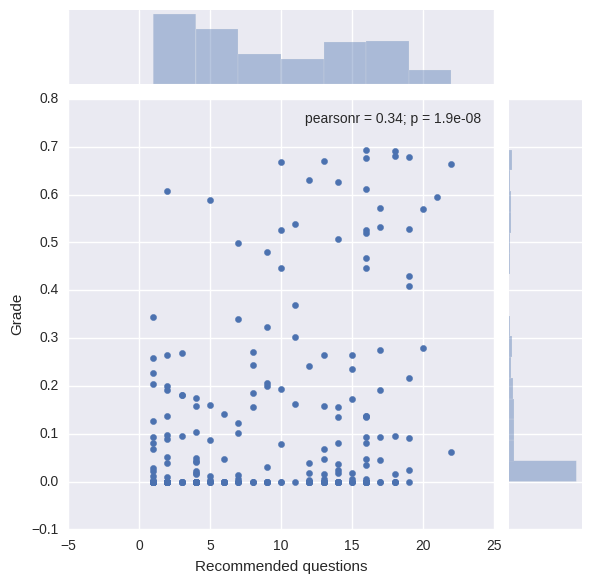

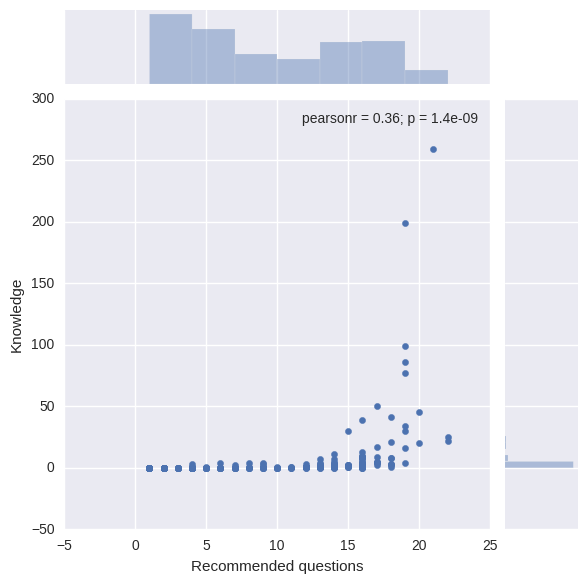

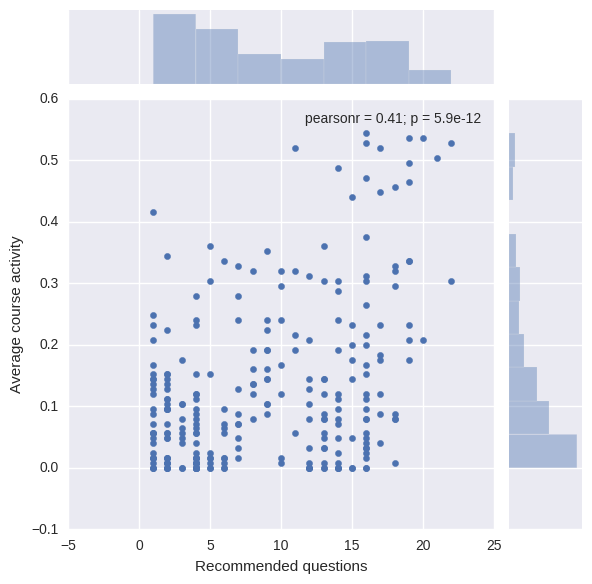

In [95]:
# Grade and number of rec
grades = psql.read_sql("""
    SELECT ab.user_id, ab.ab_group_id, COUNT(n.id) as "Recommended questions", COALESCE(value, 0) AS "Grade" 
    FROM notifications as n
    JOIN ab_groupings ab ON ab.user_id = n.recipient_id
    LEFT JOIN user_profiles up ON (up.user_id = ab.user_id AND up.property='Grade')
    WHERE n.action = 'recommendation' AND n.created_at < '2016-12-20'
    GROUP BY ab.user_id, ab.ab_group_id, value
""", connection)
sns.jointplot(x="Recommended questions", y="Grade", data=grades)

knowledge = psql.read_sql("""
    SELECT ab.user_id, ab.ab_group_id, COUNT(n.id) as "Recommended questions", COALESCE(value, 0) AS "Knowledge" 
    FROM notifications as n
    JOIN ab_groupings ab ON ab.user_id = n.recipient_id
    LEFT JOIN user_profiles up ON (up.user_id = ab.user_id AND up.property='Knowledge')
    WHERE n.action = 'recommendation' AND n.created_at < '2016-12-20'
    GROUP BY ab.user_id, ab.ab_group_id, value
    """, connection)
sns.jointplot(x="Recommended questions", y="Knowledge", data=knowledge)

avg_course_activity = psql.read_sql("""
SELECT ab.user_id, ab.ab_group_id, COUNT(n.id) as "Recommended questions", COALESCE(value, 0) AS "Average course activity" 
FROM notifications as n
JOIN ab_groupings ab ON ab.user_id = n.recipient_id
LEFT JOIN user_profiles up ON (up.user_id = ab.user_id AND up.property='AvgCourseActivity')
WHERE n.action = 'recommendation' AND n.created_at < '2016-12-20'
GROUP BY ab.user_id, ab.ab_group_id, value
    """, connection)
sns.jointplot(x="Recommended questions", y="Average course activity", data=avg_course_activity)

### Student examples of how features are related to number of recommended questions

In [88]:
students_examples = psql.read_sql("""
    SELECT DISTINCT ab.user_id, ab.ab_group_id, COUNT(n.id) as "Recommended questions", property, value
    FROM notifications as n 
    JOIN ab_groupings ab ON ab.user_id = n.recipient_id
    JOIN user_profiles up ON (up.user_id = ab.user_id)
    WHERE n.action = 'recommendation' AND n.created_at < '2016-12-20' AND up.targetable_id = -1
    AND ab.user_id IN (17, 2298)
    GROUP BY ab.ab_group_id, ab.user_id, property, value
    ORDER BY ab.user_id
""", connection)
display(students_examples.ix[:5])
students_examples.ix[[8,9,10,11,12,13]]

,user_id,ab_group_id,Recommended questions,property,value
0,17,1,13,AvgCourseActivity,0.360000
1,17,1,13,AvgCqaActivity,0.224000
2,17,1,13,CommentsCount,1.000000
3,17,1,13,Grade,0.669766
4,17,1,13,Knowledge,1.000000
5,17,1,13,QuestionCount,1.000000


,user_id,ab_group_id,Recommended questions,property,value
8,2298,1,18,AvgCourseActivity,0.45600
9,2298,1,18,AvgCqaActivity,0.21600
10,2298,1,18,Grade,0.67975
11,2298,1,18,Knowledge,1.00000
12,2298,1,18,QuestionCount,2.00000
13,2298,1,18,QuestionVotesCount,1.00000


In the tables above are interesting examples of two students from groups with educational specific recommendation (ab_group_id = 1). 

Student 2218 had one contribution in the CQA system, i.e. one comment. However, question recommendation routed 13 question to him/her as the average activity in course and grades are high for him/her.

Student 2298 had only two contribution in the CQA system, i.e. two questions. However, educational specific question recommendation routed 18 questions to him/her as his/her average activity in course and grades are high. Moreover, in our analysis we discovered that this student is from TU Delft and did this course as a part of his university studies.

Without considering NON-QA specific features from the course, these users would not be ranked as experts and fewer questions would be recommended to them. 

## Question recommendation increased question answering success rate
Question answering success rate is number of questions with at least one answer.

Note: Only questions are considered, not discussions and bug reports.

In [89]:
questions_before = psql.read_sql("""
            SELECT q.id, q.title, COUNT(a.id) AS answers_count FROM questions q 
            LEFT JOIN answers a ON (a.question_id=q.id AND a.created_at < '2016-11-14')
            WHERE q.created_at < '2016-11-14' AND question_type_id = 1 
            GROUP BY q.id
            """,connection)

questions_during = psql.read_sql("""
            SELECT q.id, q.title, COUNT(a.id) AS answers_count FROM questions q 
            LEFT JOIN answers a ON (a.question_id=q.id AND a.created_at >= '2016-11-14' 
                                    AND a.created_at < '2016-12-20')
            WHERE q.created_at >= '2016-11-14' AND q.created_at < '2016-12-20' AND question_type_id = 1 
            GROUP BY q.id
            """,connection)
before_success_rate = (questions_before['answers_count'] != 0).sum()*100 / float(len(questions_before))
during_success_rate = (questions_during['answers_count'] != 0).sum()*100 / float(len(questions_during))

print("Success rate before online experiment: %.3f %%" % before_success_rate)
print("Success rate during online experiment: %.3f %%" % during_success_rate)

Success rate before online experiment: 77.632 %
Success rate during online experiment: 79.452 %


### Average answer quality decreased with the question recommendation
Quality of answers is estimated by number of earned votes for a particular answer.

In [90]:
quality = psql.read_sql("""
            SELECT (SELECT AVG(a.votes_difference) FROM answers a
            JOIN questions q ON q.id=a.question_id
            WHERE a.created_at < '2016-11-14') as quality_before, 
            (SELECT AVG(a.votes_difference) FROM answers a
            JOIN questions q ON q.id=a.question_id
            WHERE a.created_at >= '2016-11-14' AND a.created_at < '2016-12-20') as quality_during
          """, connection)
quality

,quality_before,quality_during
0,0.521236,0.40146


In [91]:
not_rec_answers= psql.read_sql("""
        SELECT g.value as "ab_group", a.id, a.votes_difference FROM answers a
        JOIN questions q ON q.id=a.question_id
        JOIN ab_groupings ab ON a.author_id=ab.user_id
        JOIN ab_groups g ON g.id=ab.ab_group_id
        WHERE a.created_at >= '2016-11-14' AND a.created_at < '2016-12-20'
        """, connection)

not_rec_answers = not_rec_answers[~not_rec_answers['id'].isin(answers_success_rec['id'].unique())]
display(not_rec_answers.groupby('ab_group')['votes_difference'].mean().to_frame(name = 'Average votes of answers for not recommended questions').reset_index())

answers_success_rec_groups = pd.merge(answers_success_rec, ab_groups, on="ab_group_id")
answers_success_rec_groups.groupby('Name')['votes_difference'].mean().to_frame(name = 'Average votes of answers for recommended question').reset_index()

,ab_group,Average votes of answers for not recommended questions
0,Baseline,0.8
1,Control,0.3
2,Educational context,0.4


,Name,Average votes of answers for recommended question
0,Baseline,1.0
1,Educational context,0.6


Answers of users from baseline group has highest votes value.

Average votes value is higher for answers to recommended questions.

### Average time to answer increased with a recommendation

In [92]:
before_answers_time = psql.read_sql("""
            SELECT q.id, q.created_at, MIN(a.created_at) AS first_answer_time FROM questions q
            JOIN answers a ON (a.question_id=q.id AND a.created_at < '2016-11-14')
            WHERE q.created_at < '2016-11-14'
            GROUP BY q.id
            """,connection)

during_answers_time = psql.read_sql("""
            SELECT q.id, q.created_at, MIN(a.created_at) AS first_answer_time FROM questions q
            JOIN answers a ON (a.question_id=q.id AND a.created_at >= '2016-11-14' AND a.created_at < '2016-12-20')
            WHERE q.created_at >= '2016-11-14' AND q.created_at < '2016-12-20'
            GROUP BY q.id
            """,connection)

print("Average time to answer:")
avg_time_before = (before_answers_time['first_answer_time'] - before_answers_time['created_at']).sum() / len(before_answers_time) 
print("\tbefore online experiment: %s" % avg_time_before)

avg_time_during = (during_answers_time['first_answer_time'] - during_answers_time['created_at']).sum() / len(during_answers_time)
print("\tduring online experiment: %s" % avg_time_during)

print("Average time to answer increased with question recommendation by: %s" % (avg_time_during - avg_time_before))

during_answer_time_by_groups = psql.read_sql("""
        SELECT q.id, q.created_at, a.author_id, a.created_at AS first_answer_time, ab.ab_group_id, g.value as "ab_group"
        FROM questions q
        JOIN (  SELECT id, author_id, question_id, created_at, rank() OVER ( 
                PARTITION BY question_id ORDER BY created_at ASC) FROM answers
        ) AS a ON (a.question_id=q.id AND a.rank = 1 AND a.created_at >= '2016-11-14' AND a.created_at < '2016-12-20')
        JOIN ab_groupings ab ON a.author_id=ab.user_id
        JOIN ab_groups g ON g.id=ab.ab_group_id
        WHERE q.created_at >= '2016-11-14' AND q.created_at < '2016-12-20'
        """, connection)
during_answer_time_by_groups['time_diff'] = during_answer_time_by_groups['first_answer_time'] - during_answer_time_by_groups['created_at']
during_answer_time_by_groups['time_diff'] = during_answer_time_by_groups['time_diff'].astype('timedelta64[h]')
during_answer_time_by_groups = during_answer_time_by_groups.groupby('ab_group')['time_diff'].agg(['count', 'mean']).reset_index()
during_answer_time_by_groups.rename(columns = {'mean':'Average time to answer', 'count': 'Answer count'}, inplace = True)
#during_answer_time_by_groups['Average time to answer'] = during_answer_time_by_groups['Average time to answer'].astype('timedelta')
during_answer_time_by_groups

Average time to answer:
	before online experiment: 1 days 00:25:24.515813
	during online experiment: 1 days 16:00:44.794221
Average time to answer increased with question recommendation by: 0 days 15:35:20.278407


,ab_group,Answer count,Average time to answer
0,Baseline,3,27.333333
1,Control,29,50.896552
2,Educational context,57,35.649123


Average time to answer increased during the online experiment. However, it might be related with higher difficulty of the course and less number of active users. Therefore, time to answer in groups is more relevant. **Users with recommendation (baseline, educational context) has significantly lower average time to answer than control group by 33 and 15 hours.**

Note: Only first answer for a question is considered.

### Contributing users for each week compared to active users in a week did not change
Contribution is defined as asking, answering and commenting. Active user is a user who saw any question during a particular week.

In [93]:
contributing_users = psql.read_sql("""
    SELECT date_trunc('week', a.created_at::date) AS weekly, COUNT(DISTINCT(a.initiator_id)) as "Contributing users"
    FROM activities a
    WHERE a.resource_type IN ('Shared::Question', 'Shared::Answer', 'Shared::Comment')
    AND a.created_at > '2016-10-03' AND a.created_at < '2016-12-19' AND a.action='create'
    GROUP BY weekly
    ORDER BY weekly
          """, connection)
active_users = psql.read_sql("""
    SELECT date_trunc('week', a.created_at::date) AS weekly, COUNT(DISTINCT(a.initiator_id)) as "Active users" 
    FROM activities a
    WHERE a.created_at > '2016-10-03' AND a.created_at < '2016-12-19' AND a.action='create'
    GROUP BY weekly
    ORDER BY weekly
          """, connection)
users = pd.merge(contributing_users, active_users, on='weekly', how='inner')
users['Contributing to active portion'] = users['Contributing users']*100 / users['Active users']
display(users.ix[1:5])
display(users.ix[6:])

print("Recommendation effect size: %.3f" % (users.ix[6:]['Contributing to active portion'].mean() - users.ix[1:5]['Contributing to active portion'].mean()))

,weekly,Contributing users,Active users,Contributing to active portion
1,2016-10-10 00:00:00+02:00,48,1661,2.889825
2,2016-10-17 00:00:00+02:00,52,919,5.658324
3,2016-10-24 00:00:00+02:00,36,730,4.931507
4,2016-10-31 00:00:00+01:00,26,614,4.234528
5,2016-11-07 00:00:00+01:00,21,513,4.093567


,weekly,Contributing users,Active users,Contributing to active portion
6,2016-11-14 00:00:00+01:00,23,535,4.299065
7,2016-11-21 00:00:00+01:00,27,478,5.648536
8,2016-11-28 00:00:00+01:00,23,617,3.727715
9,2016-12-05 00:00:00+01:00,21,463,4.535637
10,2016-12-12 00:00:00+01:00,31,545,5.688073


Recommendation effect size: 0.418


## Anova

In [94]:
df = psql.read_sql("""
    SELECT a.author_id, ab.ab_group_id, a.votes_difference, (a.created_at - q.created_at) as "time to answer" FROM answers a JOIN ab_groupings ab ON a.author_id = ab.user_id
    JOIN questions q ON q.id=a.question_id 
    WHERE q.created_at >= '2016-11-14' AND q.created_at < '2016-12-20'
    """, connection)
df['time to answer'] = df['time to answer'].astype('timedelta64[m]')

full_rec_group = df[df['ab_group_id'] == 1].copy().reset_index()
baseline_rec_group = df[df['ab_group_id'] == 2].copy().reset_index()
control_group = df[df['ab_group_id'] == 3].copy().reset_index()

print("Votes difference: \t\t\tEducational %.3f \tBaseline %.3f \t\t\tControl %.3f" % (full_rec_group['votes_difference'].mean(), baseline_rec_group['votes_difference'].mean(), control_group['votes_difference'].mean()))
print("Time to answer difference[in hourse]: \tEducational %.3f \tBaseline %.3f \t\tControl %.3f" % (full_rec_group['time to answer'].mean(), baseline_rec_group['time to answer'].mean(), control_group['time to answer'].mean()))

display(stats.ttest_ind(full_rec_group['votes_difference'], control_group['votes_difference']))
display(stats.ttest_ind(full_rec_group['time to answer'], control_group['time to answer']))
#stats.f_oneway(full_rec_group, baseline_rec_group, control_group)
len(baseline_rec_group)

Votes difference: 			Educational 0.461 	Baseline 0.800 			Control 0.326
Time to answer difference[in hourse]: 	Educational 3957.645 	Baseline 1587.400 		Control 5068.349


Ttest_indResult(statistic=0.85348495023836102, pvalue=0.39513440238093112)

Ttest_indResult(statistic=-0.86860745941640438, pvalue=0.38684013324814959)

5

Answer quality and time to first answers was preserved during online experiment.